### All Data

In [3]:
import pandas as pd
import numpy as np

In [17]:
df = pd.read_csv("full_context_v1_embeddings.csv", nrows = 50000)

In [3]:
np.linalg.norm(df.drop('IDpol', axis = 1))

np.float64(223.60664163592506)

In [18]:
test_df=df.drop('IDpol', axis = 1)
df_normalized = test_df / np.linalg.norm(test_df)

In [5]:
np.linalg.norm(df_normalized)

np.float64(1.0000000000000193)

In [19]:
# Assuming df_normalized is your DataFrame and df["IDpol"] is your Series
df = pd.concat([df["IDpol"],df_normalized], axis=1)

In [20]:
dat = pd.read_csv("freMTPL2freq.csv", usecols = ['IDpol','ClaimNb','Exposure'],nrows = 50000)

In [8]:
dat["IDpol"].nunique()

50000

In [9]:
dat

,IDpol,ClaimNb,Exposure
0,1.0,1,0.10
1,3.0,1,0.77
2,5.0,1,0.75
3,10.0,1,0.09
4,11.0,1,0.84
...,...,...,...
49995,101258.0,0,0.83
49996,101260.0,0,0.09
49997,101261.0,0,0.77
49998,101263.0,0,0.02


In [21]:
# Inner join on the 'key' column
merged_df = pd.merge(df, dat, on='IDpol', how='left')
merged_df=merged_df.drop('IDpol', axis = 1)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 2. Split Data
# ---------------------------------------------------------
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

# Save to current directory
# train_df.to_csv('train_df_emb.csv', index=False)

# test_df.to_csv('test_df_emb.csv', index=False)

# Separate Predictors from Meta Data
# Using .difference() is safer/faster for 3000 columns
meta_cols = ['ClaimNb', 'Exposure']
pred_cols = merged_df.columns.difference(meta_cols)

X_train = train_df[pred_cols]
meta_train = train_df[meta_cols]

X_test = test_df[pred_cols]
meta_test = test_df[meta_cols]

# 3. Setup Scaler & PCA with Pandas Output
# ---------------------------------------------------------
# This tiny change saves you lines of code:
scaler = StandardScaler().set_output(transform='pandas')
pca = PCA(n_components=100).set_output(transform='pandas')

# 4. Pipeline Execution
# ---------------------------------------------------------
# TRAIN: Fit & Transform
# Scaler returns a DF with index preserved -> PCA returns a DF with index preserved
X_train_scaled = scaler.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_scaled)

# TEST: Transform Only
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

# 5. Fast Reconstruction
# ---------------------------------------------------------
# Because indices are preserved, pandas aligns rows automatically.
# We can also rename columns cleanly if we want "PC1" instead of "pca0"

# Optional: Rename columns from 'pca0' to 'PC1', 'PC2'...
new_col_names = [f"PC{i+1}" for i in range(100)]
X_train_pca.columns = new_col_names
X_test_pca.columns = new_col_names

# Concatenate (Join)
final_train = pd.concat([X_train_pca, meta_train], axis=1)
final_test = pd.concat([X_test_pca, meta_test], axis=1)

print(f"Original Predictors: {len(pred_cols)}")
print(f"Reduced Predictors:  {X_train_pca.shape[1]}")
print(f"Final Train Shape:   {final_train.shape}")
print(final_train.head())

Original Predictors: 3072
Reduced Predictors:  100
Final Train Shape:   (40000, 102)
             PC1        PC2        PC3        PC4        PC5       PC6  \
39087  -4.992341  11.079446   3.385449   4.491205 -12.378396  5.663854   
30893 -37.076740   9.155204 -13.285009 -15.136408   8.526821 -2.119104   
45278   3.255124   6.762836  -3.137013 -12.799289   4.258043 -2.559886   
16398   8.353624   7.995768  14.124133 -16.021856  -0.137737  5.828949   
13653  -8.227137  21.566876   6.447335   4.868054   2.224088 -8.922822   

             PC7       PC8        PC9      PC10  ...      PC93      PC94  \
39087  -0.075450 -7.921754   5.047319  0.302158  ... -0.208688 -0.088516   
30893   6.379775  7.880812  -0.444637  0.313916  ... -2.717253 -0.207461   
45278  16.178161 -8.999828  24.848365  4.501549  ...  4.595538 -0.663706   
16398   0.732183 -6.848697  -7.076673 -4.789122  ... -2.604141 -0.887679   
13653   2.902643  2.187871   1.103400  7.558718  ... -1.200573 -2.688963   

           PC

In [20]:
import statsmodels.api as sm
import numpy as np

# ---------------------------------------------------------
# 1. Prepare Training Data
# ---------------------------------------------------------
# Identify predictor columns (The PCs)
# We exclude 'response' and 'offset' to get just the X matrix
predictors = [c for c in final_train.columns if c not in ['ClaimNb', 'Exposure']]

X_train = final_train[predictors]
y_train = final_train['ClaimNb']

# CRITICAL: Statsmodels does not add an intercept by default.
# PCA centers data, but you still need an intercept for the baseline rate.
X_train = sm.add_constant(X_train)

# Define the offset for training
# NOTE: If 'offset' is raw exposure (e.g., years), use np.log(final_train['offset'])
train_offset = np.log(final_train['Exposure'])

# ---------------------------------------------------------
# 2. Fit the Poisson GLM
# ---------------------------------------------------------
# Instantiate the model
glm_model = sm.GLM(
    endog=y_train, 
    exog=X_train, 
    offset=train_offset,
    family=sm.families.Poisson()
)

# Fit the model
results = glm_model.fit()

print(results.summary())

# ---------------------------------------------------------
# 3. Predict on Test Data
# ---------------------------------------------------------
X_test = final_test[predictors]
X_test = sm.add_constant(X_test, has_constant='add') # Ensure structure matches Train

# Define offset for testing
test_offset = np.log(final_test['Exposure'])

# Generate Predictions (Expected Counts)
# We pass the test offset here so predictions are scaled correctly
predictions = results.predict(exog=X_test, offset=test_offset)

# Add predictions back to the test dataframe for analysis
final_test['predicted_counts'] = predictions

print("\nFirst 5 Predictions:")
print(final_test[['ClaimNb', 'Exposure', 'predicted_counts']].head())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:                40000
Model:                            GLM   Df Residuals:                    39899
Model Family:                 Poisson   Df Model:                          100
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24081.
Date:                Thu, 27 Nov 2025   Deviance:                       29154.
Time:                        13:21:05   Pearson chi2:                 1.30e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2299
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1375      0.013    -90.704      0.0

In [13]:
# 1. Access the Poisson family object from your fitted model
poisson_family = results.family

# 2. Calculate Total Deviance for the Test Set
# Inputs: (Endog/Actual, Mu/Predicted)
test_deviance_total = poisson_family.deviance(
    final_test['ClaimNb'], 
    final_test['predicted_counts']
)

# 3. Calculate Mean Deviance
test_mean_deviance = test_deviance_total / len(final_test)

print(f"Test Mean Poisson Deviance: {test_mean_deviance:.4f}")

Test Mean Poisson Deviance: 0.7390


In [14]:
from sklearn.metrics import mean_poisson_deviance


mpd = mean_poisson_deviance(final_test['ClaimNb'], predictions)
print("Mean Poisson Deviance:", mpd)
# 2.431822393284754

Mean Poisson Deviance: 0.7389563278141313


PCA fit complete. Shape: (40000, 500)
Optimal Components: 460 (Deviance: 0.7192)


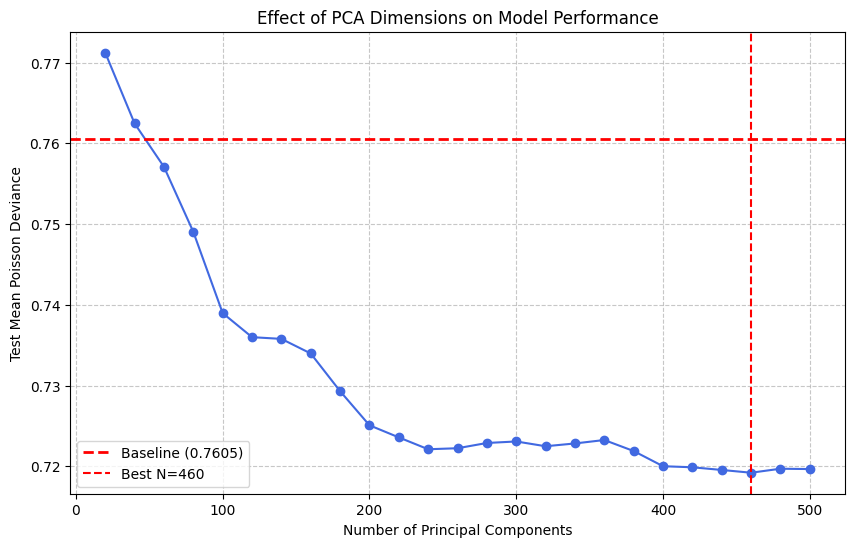

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance
import statsmodels.api as sm

# 1. Setup & Split
# -------------------------------------------------------
# (Assuming df is loaded)
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

meta_cols = ['ClaimNb', 'Exposure']
pred_cols = merged_df.columns.difference(meta_cols)

X_train_raw = train_df[pred_cols]
y_train = train_df['ClaimNb']
offset_train = train_df['Exposure'] 

X_test_raw = test_df[pred_cols]
y_test = test_df['ClaimNb']
offset_test = test_df['Exposure']

# 2. Scale & Run PCA ONCE (The Optimization)
# -------------------------------------------------------
scaler = StandardScaler().set_output(transform='pandas')
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Fit PCA for the MAXIMUM number of components you want to test (e.g., 50)
max_n = 500
pca = PCA(n_components=max_n).set_output(transform='pandas')

# Create the "Master" PCA DataFrames
X_train_pca_all = pca.fit_transform(X_train_scaled)
X_test_pca_all = pca.transform(X_test_scaled)

print(f"PCA fit complete. Shape: {X_train_pca_all.shape}")

# 3. Efficient Loop via Slicing
# -------------------------------------------------------
deviances = []
step_size = 20
# range(start, stop, step) -> 10, 20, 30 ... 100
component_counts = range(20, max_n + 1, step_size)

for n in component_counts:
    # Slice the first n columns from the Master PCA DF
    # .iloc[:, :n] takes all rows (:), and columns 0 to n
    X_train_slice = X_train_pca_all.iloc[:, :n]
    X_test_slice = X_test_pca_all.iloc[:, :n]
    
    # Add constant to the slice (Statsmodels needs this every time)
    X_train_glm = sm.add_constant(X_train_slice)
    X_test_glm = sm.add_constant(X_test_slice, has_constant='add')
    
    # Fit GLM
    glm = sm.GLM(
        endog=y_train, 
        exog=X_train_glm, 
        offset=np.log(offset_train), 
        family=sm.families.Poisson()
    )
    results = glm.fit()
    
    # Predict
    preds = results.predict(exog=X_test_glm, offset=np.log(offset_test))
    
    # Score
    mpd = mean_poisson_deviance(y_test, preds)
    deviances.append(mpd)

target_y = 0.7605
# 4. Plotting
# -------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(component_counts, deviances, marker='o', linestyle='-', color='royalblue')
plt.axhline(y=target_y, color='red', linestyle='--', linewidth=2, label=f'Baseline ({target_y})')
plt.title('Effect of PCA Dimensions on Model Performance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Test Mean Poisson Deviance')
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight the minimum
min_deviance = min(deviances)
best_n = component_counts[deviances.index(min_deviance)]
plt.axvline(best_n, color='red', linestyle='--', label=f'Best N={best_n}')
plt.legend()

plt.savefig('pca_500.png')
print(f"Optimal Components: {best_n} (Deviance: {min_deviance:.4f})")

PCA fit complete. Shape: (40000, 100)
Optimal Components: 100 (Deviance: 0.7390)


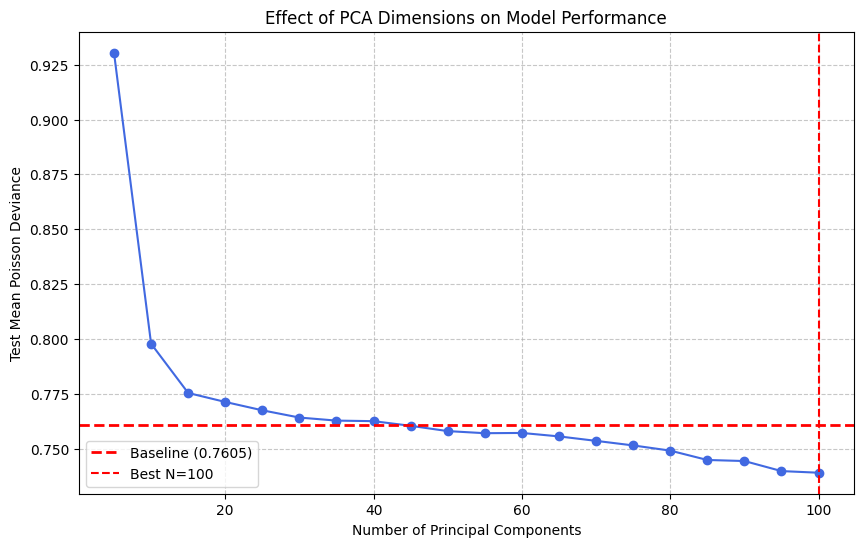

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance
import statsmodels.api as sm

# 1. Setup & Split
# -------------------------------------------------------
# (Assuming df is loaded)
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

meta_cols = ['ClaimNb', 'Exposure']
pred_cols = merged_df.columns.difference(meta_cols)

X_train_raw = train_df[pred_cols]
y_train = train_df['ClaimNb']
offset_train = train_df['Exposure'] 

X_test_raw = test_df[pred_cols]
y_test = test_df['ClaimNb']
offset_test = test_df['Exposure']

# 2. Scale & Run PCA ONCE (The Optimization)
# -------------------------------------------------------
scaler = StandardScaler().set_output(transform='pandas')
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Fit PCA for the MAXIMUM number of components you want to test (e.g., 50)
max_n = 100
pca = PCA(n_components=max_n).set_output(transform='pandas')

# Create the "Master" PCA DataFrames
X_train_pca_all = pca.fit_transform(X_train_scaled)
X_test_pca_all = pca.transform(X_test_scaled)

print(f"PCA fit complete. Shape: {X_train_pca_all.shape}")

# 3. Efficient Loop via Slicing
# -------------------------------------------------------
deviances = []
step_size = 5
# range(start, stop, step) -> 10, 20, 30 ... 100
component_counts = range(5, max_n + 1, step_size)

for n in component_counts:
    # Slice the first n columns from the Master PCA DF
    # .iloc[:, :n] takes all rows (:), and columns 0 to n
    X_train_slice = X_train_pca_all.iloc[:, :n]
    X_test_slice = X_test_pca_all.iloc[:, :n]
    
    # Add constant to the slice (Statsmodels needs this every time)
    X_train_glm = sm.add_constant(X_train_slice)
    X_test_glm = sm.add_constant(X_test_slice, has_constant='add')
    
    # Fit GLM
    glm = sm.GLM(
        endog=y_train, 
        exog=X_train_glm, 
        offset=np.log(offset_train), 
        family=sm.families.Poisson()
    )
    results = glm.fit()
    
    # Predict
    preds = results.predict(exog=X_test_glm, offset=np.log(offset_test))
    
    # Score
    mpd = mean_poisson_deviance(y_test, preds)
    deviances.append(mpd)

target_y = 0.7605
# 4. Plotting
# -------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(component_counts, deviances, marker='o', linestyle='-', color='royalblue')
plt.axhline(y=target_y, color='red', linestyle='--', linewidth=2, label=f'Baseline ({target_y})')
plt.title('Effect of PCA Dimensions on Model Performance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Test Mean Poisson Deviance')
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight the minimum
min_deviance = min(deviances)
best_n = component_counts[deviances.index(min_deviance)]
plt.axvline(best_n, color='red', linestyle='--', label=f'Best N={best_n}')
plt.legend()

plt.savefig('pca_deviance_plot.png')
print(f"Optimal Components: {best_n} (Deviance: {min_deviance:.4f})")

PCA fit complete. Shape: (40000, 250)


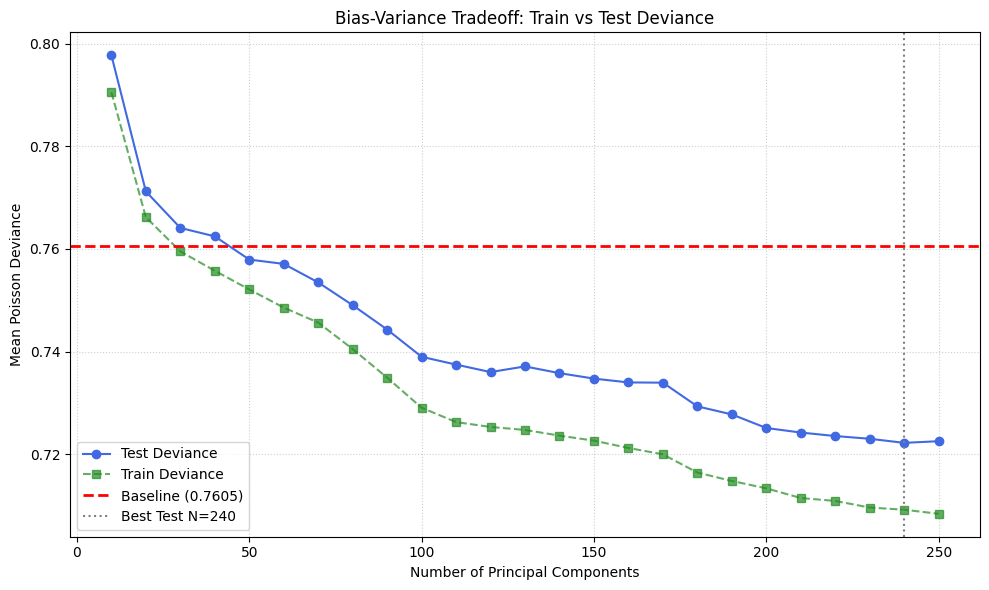

Optimal Test Components: 240 (Deviance: 0.7222)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance
import statsmodels.api as sm

# 1. Setup & Split
# -------------------------------------------------------
# (Assuming merged_df is loaded)
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

meta_cols = ['ClaimNb', 'Exposure']
pred_cols = merged_df.columns.difference(meta_cols)

X_train_raw = train_df[pred_cols]
y_train = train_df['ClaimNb']
offset_train = train_df['Exposure'] 

X_test_raw = test_df[pred_cols]
y_test = test_df['ClaimNb']
offset_test = test_df['Exposure']

# 2. Scale & Run PCA ONCE
# -------------------------------------------------------
scaler = StandardScaler().set_output(transform='pandas')
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

max_n = 250
pca = PCA(n_components=max_n).set_output(transform='pandas')

X_train_pca_all = pca.fit_transform(X_train_scaled)
X_test_pca_all = pca.transform(X_test_scaled)

print(f"PCA fit complete. Shape: {X_train_pca_all.shape}")

# 3. Efficient Loop via Slicing
# -------------------------------------------------------
test_deviances = []
train_deviances = []  # <--- New List for Train Scores
step_size = 10
component_counts = range(10, max_n + 1, step_size)

for n in component_counts:
    # Slice
    X_train_slice = X_train_pca_all.iloc[:, :n]
    X_test_slice = X_test_pca_all.iloc[:, :n]
    
    # Add constant
    X_train_glm = sm.add_constant(X_train_slice)
    X_test_glm = sm.add_constant(X_test_slice, has_constant='add')
    
    # Fit GLM
    glm = sm.GLM(
        endog=y_train, 
        exog=X_train_glm, 
        offset=np.log(offset_train), 
        family=sm.families.Poisson()
    )
    results = glm.fit()
    
    # A. Predict on TEST
    test_preds = results.predict(exog=X_test_glm, offset=np.log(offset_test))
    test_mpd = mean_poisson_deviance(y_test, test_preds)
    test_deviances.append(test_mpd)
    
    # B. Predict on TRAIN (New Step)
    train_preds = results.predict(exog=X_train_glm, offset=np.log(offset_train))
    train_mpd = mean_poisson_deviance(y_train, train_preds)
    train_deviances.append(train_mpd)

# 4. Plotting Both Curves
# -------------------------------------------------------
target_y = 0.7605

plt.figure(figsize=(10, 6))

# Plot Test Deviance (Blue)
plt.plot(component_counts, test_deviances, marker='o', linestyle='-', color='royalblue', label='Test Deviance')

# Plot Train Deviance (Green - Dashed)
plt.plot(component_counts, train_deviances, marker='s', linestyle='--', color='forestgreen', alpha=0.7, label='Train Deviance')

# Plot Baseline
plt.axhline(y=target_y, color='red', linestyle='--', linewidth=2, label=f'Baseline ({target_y})')

plt.title('Bias-Variance Tradeoff: Train vs Test Deviance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Mean Poisson Deviance')
plt.grid(True, linestyle=':', alpha=0.6)

# Find Best Test N
min_test_dev = min(test_deviances)
best_n = component_counts[test_deviances.index(min_test_dev)]
plt.axvline(best_n, color='gray', linestyle=':', label=f'Best Test N={best_n}')

plt.legend()
plt.tight_layout()
plt.savefig('pca_bias_variance_plot.png')
plt.show()

print(f"Optimal Test Components: {best_n} (Deviance: {min_test_dev:.4f})")

PCA fit complete. Shape: (40000, 100)


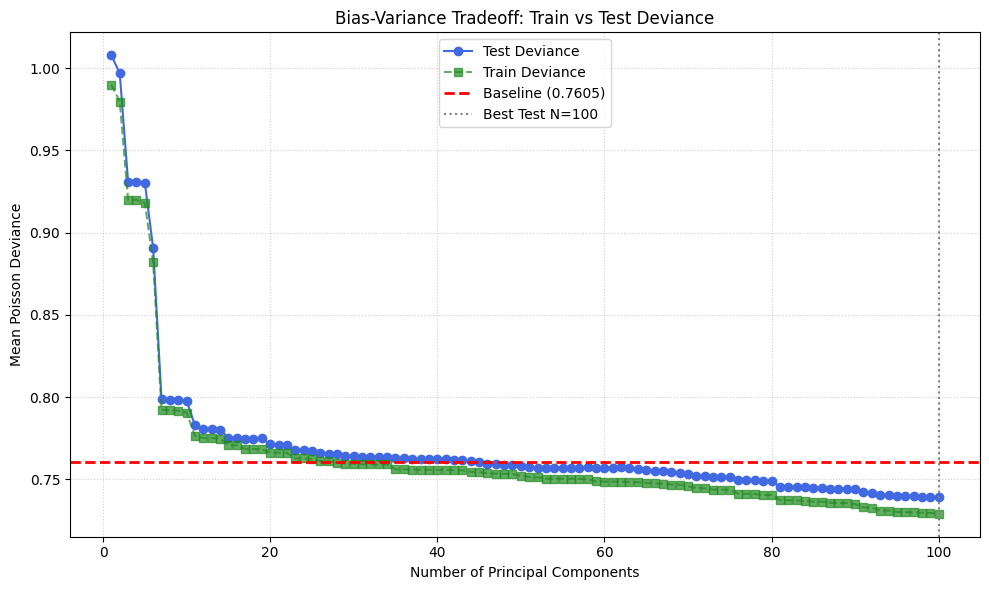

Optimal Test Components: 100 (Deviance: 0.7390)


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance
import statsmodels.api as sm

# 1. Setup & Split
# -------------------------------------------------------
# (Assuming merged_df is loaded)
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

meta_cols = ['ClaimNb', 'Exposure']
pred_cols = merged_df.columns.difference(meta_cols)

X_train_raw = train_df[pred_cols]
y_train = train_df['ClaimNb']
offset_train = train_df['Exposure'] 

X_test_raw = test_df[pred_cols]
y_test = test_df['ClaimNb']
offset_test = test_df['Exposure']

# 2. Scale & Run PCA ONCE
# -------------------------------------------------------
scaler = StandardScaler().set_output(transform='pandas')
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

max_n = 100
pca = PCA(n_components=max_n).set_output(transform='pandas')

X_train_pca_all = pca.fit_transform(X_train_scaled)
X_test_pca_all = pca.transform(X_test_scaled)

print(f"PCA fit complete. Shape: {X_train_pca_all.shape}")

# 3. Efficient Loop via Slicing
# -------------------------------------------------------
test_deviances = []
train_deviances = []  # <--- New List for Train Scores
step_size = 1
component_counts = range(1, max_n + 1, step_size)

for n in component_counts:
    # Slice
    X_train_slice = X_train_pca_all.iloc[:, :n]
    X_test_slice = X_test_pca_all.iloc[:, :n]
    
    # Add constant
    X_train_glm = sm.add_constant(X_train_slice)
    X_test_glm = sm.add_constant(X_test_slice, has_constant='add')
    
    # Fit GLM
    glm = sm.GLM(
        endog=y_train, 
        exog=X_train_glm, 
        offset=np.log(offset_train), 
        family=sm.families.Poisson()
    )
    results = glm.fit()
    
    # A. Predict on TEST
    test_preds = results.predict(exog=X_test_glm, offset=np.log(offset_test))
    test_mpd = mean_poisson_deviance(y_test, test_preds)
    test_deviances.append(test_mpd)
    
    # B. Predict on TRAIN (New Step)
    train_preds = results.predict(exog=X_train_glm, offset=np.log(offset_train))
    train_mpd = mean_poisson_deviance(y_train, train_preds)
    train_deviances.append(train_mpd)

# 4. Plotting Both Curves
# -------------------------------------------------------
target_y = 0.7605

plt.figure(figsize=(10, 6))

# Plot Test Deviance (Blue)
plt.plot(component_counts, test_deviances, marker='o', linestyle='-', color='royalblue', label='Test Deviance')

# Plot Train Deviance (Green - Dashed)
plt.plot(component_counts, train_deviances, marker='s', linestyle='--', color='forestgreen', alpha=0.7, label='Train Deviance')

# Plot Baseline
plt.axhline(y=target_y, color='red', linestyle='--', linewidth=2, label=f'Baseline ({target_y})')

plt.title('Bias-Variance Tradeoff: Train vs Test Deviance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Mean Poisson Deviance')
plt.grid(True, linestyle=':', alpha=0.6)

# Find Best Test N
min_test_dev = min(test_deviances)
best_n = component_counts[test_deviances.index(min_test_dev)]
plt.axvline(best_n, color='gray', linestyle=':', label=f'Best Test N={best_n}')

plt.legend()
plt.tight_layout()
plt.savefig('pca_bias_variance_plot_focused.png')
plt.show()

print(f"Optimal Test Components: {best_n} (Deviance: {min_test_dev:.4f})")

Test Set Size (Fixed): 10000 rows
----------------------------------------
Training on 2000 rows (  5%) -> Deviance: 0.7801
Training on 4000 rows ( 10%) -> Deviance: 0.7655
Training on 6000 rows ( 15%) -> Deviance: 0.7641
Training on 8000 rows ( 20%) -> Deviance: 0.7615
Training on 10000 rows ( 25%) -> Deviance: 0.7598
Training on 12000 rows ( 30%) -> Deviance: 0.7596
Training on 14000 rows ( 35%) -> Deviance: 0.7609
Training on 15999 rows ( 40%) -> Deviance: 0.7603
Training on 18000 rows ( 45%) -> Deviance: 0.7590
Training on 19999 rows ( 50%) -> Deviance: 0.7587
Training on 21999 rows ( 55%) -> Deviance: 0.7588
Training on 24000 rows ( 60%) -> Deviance: 0.7586
Training on 26000 rows ( 65%) -> Deviance: 0.7585
Training on 28000 rows ( 70%) -> Deviance: 0.7587
Training on 30000 rows ( 75%) -> Deviance: 0.7591
Training on 31999 rows ( 80%) -> Deviance: 0.7591
Training on 34000 rows ( 85%) -> Deviance: 0.7590
Training on 36000 rows ( 90%) -> Deviance: 0.7592
Training on 38000 rows ( 95%)

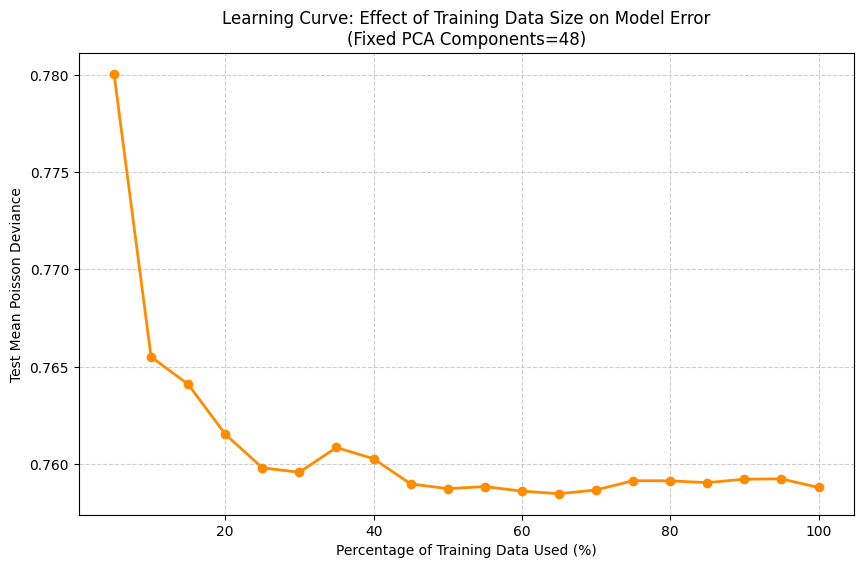

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance
import statsmodels.api as sm

# 2. Initial Fixed Split (The "Fair Comparison" Setup)
# -------------------------------------------------------
# We hold out 20% as a fixed benchmark. 
# We will never train on this, only evaluate.
train_full, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

meta_cols = ['ClaimNb', 'Exposure']
pred_cols = merged_df.columns.difference(meta_cols)

# Prepare the Fixed Test Set
X_test_raw = test_df[pred_cols]
y_test = test_df['ClaimNb']
offset_test = test_df['Exposure']

# 3. Learning Curve Loop
# -------------------------------------------------------
train_proportions = np.linspace(0.05, 1.0, 20) # 10%, 20% ... 100%
deviances = []
n_pca_components = 48 # Keep model complexity constant to isolate data size effect

print(f"Test Set Size (Fixed): {len(test_df)} rows")
print("-" * 40)

for prop in train_proportions:
    # A. Subsample the Training Data
    # We take the first N rows (shuffling happened in train_test_split already)
    n_samples = int(len(train_full) * prop)
    train_subset = train_full.iloc[:n_samples]
    
    # Prepare Subset Matrices
    X_train_sub = train_subset[pred_cols]
    y_train_sub = train_subset['ClaimNb']
    offset_train_sub = train_subset['Exposure']
    
    # B. Scale & PCA (Must fit on the SUBSET only)
    scaler = StandardScaler().set_output(transform='pandas')
    pca = PCA(n_components=n_pca_components).set_output(transform='pandas')
    
    # Fit on subset, Transform subset
    X_train_scaled = scaler.fit_transform(X_train_sub)
    X_train_pca = pca.fit_transform(X_train_scaled)
    
    # Transform the FIXED Test set using the subset's learners
    # (This simulates having only this much data available in real life)
    X_test_scaled = scaler.transform(X_test_raw)
    X_test_pca = pca.transform(X_test_scaled)
    
    # C. Fit GLM
    X_train_glm = sm.add_constant(X_train_pca)
    X_test_glm = sm.add_constant(X_test_pca, has_constant='add')
    
    try:
        glm = sm.GLM(
            endog=y_train_sub, 
            exog=X_train_glm, 
            offset=np.log(offset_train_sub), 
            family=sm.families.Poisson()
        )
        results = glm.fit()
        
        # D. Predict on Fixed Test Set
        preds = results.predict(exog=X_test_glm, offset=np.log(offset_test))
        mpd = mean_poisson_deviance(y_test, preds)
        deviances.append(mpd)
        print(f"Training on {n_samples:4d} rows ({prop*100:3.0f}%) -> Deviance: {mpd:.4f}")
        
    except Exception as e:
        print(f"Training on {n_samples} rows failed to converge.")
        deviances.append(None)

# 4. Plot Learning Curve
# -------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(train_proportions * 100, deviances, marker='o', linewidth=2, color='darkorange')

plt.title(f'Learning Curve: Effect of Training Data Size on Model Error\n(Fixed PCA Components={n_pca_components})')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Test Mean Poisson Deviance')
plt.grid(True, linestyle='--', alpha=0.6)


plt.show()

In [19]:
min(deviances)

0.7584741537245178

PCA fit complete. Shape: (40000, 500)


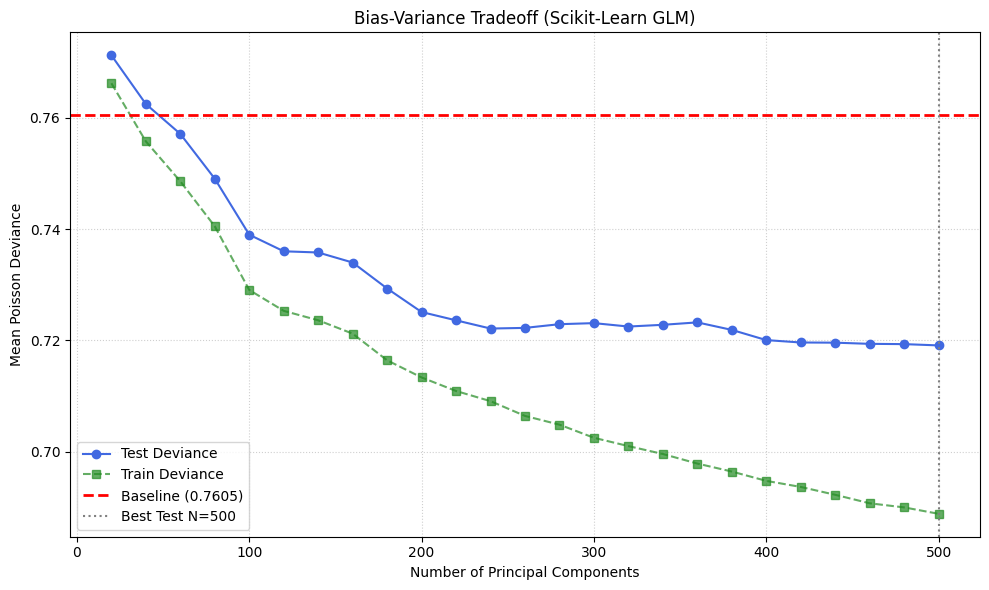

Optimal Test Components: 500 (Deviance: 0.7191)


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance
from sklearn.linear_model import PoissonRegressor # <--- New Import

# 1. Setup & Split
# -------------------------------------------------------
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

meta_cols = ['ClaimNb', 'Exposure']
pred_cols = merged_df.columns.difference(meta_cols)

# Prepare Matrices
X_train_raw = train_df[pred_cols]
y_train = train_df['ClaimNb']
offset_train = train_df['Exposure'] 

X_test_raw = test_df[pred_cols]
y_test = test_df['ClaimNb']
offset_test = test_df['Exposure']

# 2. Scale & Run PCA ONCE
# -------------------------------------------------------
scaler = StandardScaler().set_output(transform='pandas')
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

max_n = 500
pca = PCA(n_components=max_n).set_output(transform='pandas')

X_train_pca_all = pca.fit_transform(X_train_scaled)
X_test_pca_all = pca.transform(X_test_scaled)

print(f"PCA fit complete. Shape: {X_train_pca_all.shape}")

# 3. Efficient Loop (Scikit-Learn Version)
# -------------------------------------------------------
test_deviances = []
train_deviances = []
step_size = 20
component_counts = range(20, max_n + 1, step_size)

# Pre-calculate Rates for SKLearn (Target = Count / Exposure)
y_train_rate = y_train / offset_train

for n in component_counts:
    # Slice PCA columns
    # Note: No need for sm.add_constant(). SKLearn handles intercept automatically.
    X_train_slice = X_train_pca_all.iloc[:, :n]
    X_test_slice = X_test_pca_all.iloc[:, :n]
    
    # Initialize Model
    # alpha=0 removes L2 regularization (makes it behave like a standard GLM)
    glm = PoissonRegressor(alpha=0, fit_intercept=True, max_iter=1000)
    
    # Fit (Using Rate & Weight trick for Offset)
    glm.fit(X_train_slice, y_train_rate, sample_weight=offset_train)
    
    # A. Predict on TEST
    # Sklearn predicts the RATE. We must manually multiply by Exposure to get COUNTS.
    test_rate_preds = glm.predict(X_test_slice)
    test_count_preds = test_rate_preds * offset_test
    
    test_mpd = mean_poisson_deviance(y_test, test_count_preds)
    test_deviances.append(test_mpd)
    
    # B. Predict on TRAIN
    train_rate_preds = glm.predict(X_train_slice)
    train_count_preds = train_rate_preds * offset_train
    
    train_mpd = mean_poisson_deviance(y_train, train_count_preds)
    train_deviances.append(train_mpd)

# 4. Plotting
# -------------------------------------------------------
target_y = 0.7605

plt.figure(figsize=(10, 6))

plt.plot(component_counts, test_deviances, marker='o', linestyle='-', color='royalblue', label='Test Deviance')
plt.plot(component_counts, train_deviances, marker='s', linestyle='--', color='forestgreen', alpha=0.7, label='Train Deviance')

plt.axhline(y=target_y, color='red', linestyle='--', linewidth=2, label=f'Baseline ({target_y})')

plt.title('Bias-Variance Tradeoff (Scikit-Learn GLM)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Mean Poisson Deviance')
plt.grid(True, linestyle=':', alpha=0.6)

min_test_dev = min(test_deviances)
best_n = component_counts[test_deviances.index(min_test_dev)]
plt.axvline(best_n, color='gray', linestyle=':', label=f'Best Test N={best_n}')

plt.legend()
plt.tight_layout()
plt.show()

print(f"Optimal Test Components: {best_n} (Deviance: {min_test_dev:.4f})")

In [ ]:
# Save to current directory
# merged_df.to_csv('processed_data.csv', index=False)

# print("File saved successfully.")

File saved successfully.


Running Global PCA on full training set...
PCA Complete. Transformed shape: (40000, 48)
Trained on 1000 rows (PCA=48) | Test Deviance: 0.81419
Trained on 5000 rows (PCA=48) | Test Deviance: 0.76512
Trained on 10000 rows (PCA=48) | Test Deviance: 0.75986
Trained on 15000 rows (PCA=48) | Test Deviance: 0.76010
Trained on 20000 rows (PCA=48) | Test Deviance: 0.75881
Trained on 25000 rows (PCA=48) | Test Deviance: 0.75869
Trained on 30000 rows (PCA=48) | Test Deviance: 0.75913
Trained on 35000 rows (PCA=48) | Test Deviance: 0.75876
Trained on 40000 rows (PCA=48) | Test Deviance: 0.75865


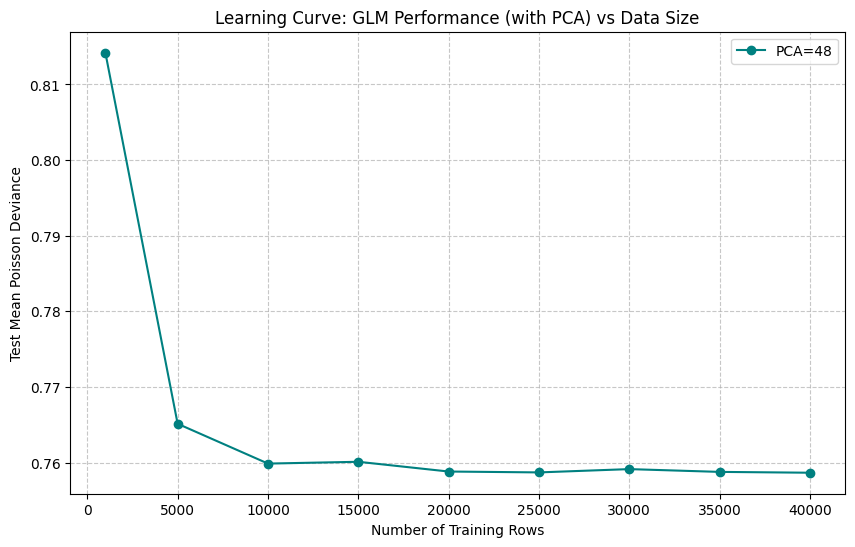

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_poisson_deviance
import statsmodels.api as sm

# 1. Setup & Split
# -------------------------------------------------------
# Split: 10,000 for Test, 40,000 for Training Pool
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

meta_cols = ['ClaimNb', 'Exposure']
pred_cols = merged_df.columns.difference(meta_cols)

# Prepare Matrices
X_train_raw = train_df[pred_cols]
y_train = train_df['ClaimNb']
offset_train = train_df['Exposure'] 

X_test_raw = test_df[pred_cols]
y_test = test_df['ClaimNb']
offset_test = test_df['Exposure']

# 2. Global Preprocessing (Scale & PCA the full Training Pool)
# -------------------------------------------------------
print("Running Global PCA on full training set...")

# A. Scale based on full 40k training data
scaler = StandardScaler().set_output(transform='pandas')
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# B. Run PCA on full 40k training data
n_components = 48  # Fix this to your desired number
pca = PCA(n_components=n_components).set_output(transform='pandas')

X_train_pca_all = pca.fit_transform(X_train_scaled)
X_test_pca_all = pca.transform(X_test_scaled)

# Pre-add constant to Test set (since it never changes)
X_test_glm = sm.add_constant(X_test_pca_all, has_constant='add')

print(f"PCA Complete. Transformed shape: {X_train_pca_all.shape}")

# 3. Learning Curve Loop
# -------------------------------------------------------
train_sizes = [1000] + list(range(5000, 40001, 5000))
deviances = []

for size in train_sizes:
    # A. Slice the first 'size' rows from the ALREADY TRANSFORMED data
    # We use .iloc because X_train_pca_all is a dataframe
    X_train_sub = X_train_pca_all.iloc[:size]
    y_train_sub = y_train.iloc[:size]
    off_train_sub = offset_train.iloc[:size]
    
    # B. Add constant for Statsmodels
    X_train_glm = sm.add_constant(X_train_sub)
    
    # C. Fit GLM
    glm = sm.GLM(
        endog=y_train_sub, 
        exog=X_train_glm, 
        offset=np.log(off_train_sub), 
        family=sm.families.Poisson()
    )
    results = glm.fit()
    
    # D. Predict on fixed Test Set
    preds = results.predict(exog=X_test_glm, offset=np.log(offset_test))
    
    # E. Score
    mpd = mean_poisson_deviance(y_test, preds)
    deviances.append(mpd)
    
    print(f"Trained on {size} rows (PCA={n_components}) | Test Deviance: {mpd:.5f}")

# 4. Plotting
# -------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, deviances, marker='o', linestyle='-', color='teal', label=f'PCA={n_components}')

plt.title('Learning Curve: GLM Performance (with PCA) vs Data Size')
plt.xlabel('Number of Training Rows')
plt.ylabel('Test Mean Poisson Deviance')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.savefig('pca_learning_curve.png')
plt.show()

## First Embeddings

In [11]:
columns_to_read = ['IDpol'] + [f'embed_{i}' for i in range(48)]

In [12]:
df2 = pd.read_csv("full_context_v1_embeddings.csv", nrows = 50000, usecols=columns_to_read)

In [13]:
test_df2=df2.drop('IDpol', axis = 1)
df_normalized2 = test_df2 / np.linalg.norm(test_df2)

In [14]:
# Assuming df_normalized is your DataFrame and df["IDpol"] is your Series
df2 = pd.concat([df2["IDpol"],df_normalized2], axis=1)

In [15]:
# Inner join on the 'key' column
merged_df2 = pd.merge(df2, dat, on='IDpol', how='left')
merged_df2=merged_df2.drop('IDpol', axis = 1)

In [16]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 2. Split Data
# ---------------------------------------------------------
train_df2, test_df2 = train_test_split(merged_df2, test_size=0.2, random_state=42)

# Separate Predictors from Meta Data
# Using .difference() is safer/faster for 3000 columns
meta_cols2 = ['ClaimNb', 'Exposure']
pred_cols2 = merged_df2.columns.difference(meta_cols2)

X_train2 = train_df2[pred_cols2]
meta_train2 = train_df2[meta_cols2]

X_test2 = test_df2[pred_cols2]
meta_test2 = test_df2[meta_cols2]

# 3. Setup Scaler & PCA with Pandas Output
# ---------------------------------------------------------
# This tiny change saves you lines of code:
scaler2 = StandardScaler().set_output(transform='pandas')
#pca = PCA(n_components=48).set_output(transform='pandas')

# 4. Pipeline Execution
# ---------------------------------------------------------
# TRAIN: Fit & Transform
# Scaler returns a DF with index preserved -> PCA returns a DF with index preserved
X_train_scaled2 = scaler2.fit_transform(X_train2)
#X_train_pca = pca.fit_transform(X_train_scaled)

# TEST: Transform Only
X_test_scaled2 = scaler2.transform(X_test2)
#X_test_pca = pca.transform(X_test_scaled)

# 5. Fast Reconstruction
# ---------------------------------------------------------

# Concatenate (Join)
final_train2 = pd.concat([X_train_scaled2, meta_train2], axis=1)
final_test2 = pd.concat([X_test_scaled2, meta_test2], axis=1)

# print(f"Original Predictors: {len(pred_cols)}")
# print(f"Reduced Predictors:  {X_train_pca.shape[1]}")
# print(f"Final Train Shape:   {final_train.shape}")
print(final_train2.head())

        embed_0   embed_1  embed_10  embed_11  embed_12  embed_13  embed_14  \
39087 -0.182614 -0.378113  0.913089 -0.855860  1.882589 -0.380430  1.380591   
30893 -0.088556  0.705045 -0.046349  0.959363  1.292482 -0.220437  2.027727   
45278  0.534408  1.288283  0.565389  0.354195 -0.154414 -0.102655 -0.628937   
16398  0.275408 -1.530705  1.579415  0.662623 -0.443793  0.606760 -1.037655   
13653  0.200434  0.288445  0.345258 -0.710153  0.089572  0.361665 -0.479074   

       embed_15  embed_16  embed_17  ...  embed_45  embed_46  embed_47  \
39087  0.689626 -0.050924 -0.187753  ... -0.393949  0.773040  0.588552   
30893  0.545377  0.091979 -0.207546  ... -0.501365 -0.082944 -0.565319   
45278 -0.162131 -1.223590  0.838417  ...  0.110944  2.289010  2.351770   
16398  1.980427  1.189009 -0.551328  ...  0.996211  0.143740 -0.431349   
13653  1.239147 -0.377723 -0.586650  ... -0.484548 -2.025578  1.712172   

        embed_5   embed_6   embed_7   embed_8   embed_9  ClaimNb  Exposure  
390

In [14]:
import statsmodels.api as sm
import numpy as np

# ---------------------------------------------------------
# 1. Prepare Training Data
# ---------------------------------------------------------
# Identify predictor columns (The PCs)
# We exclude 'response' and 'offset' to get just the X matrix
predictors2 = [c for c in final_train2.columns if c not in ['ClaimNb', 'Exposure']]

X_train2 = final_train2[predictors2]
y_train2 = final_train2['ClaimNb']

# CRITICAL: Statsmodels does not add an intercept by default.
# PCA centers data, but you still need an intercept for the baseline rate.
X_train2 = sm.add_constant(X_train2)

# Define the offset for training
# NOTE: If 'offset' is raw exposure (e.g., years), use np.log(final_train['offset'])
train_offset2 = np.log(final_train2['Exposure'])

# ---------------------------------------------------------
# 2. Fit the Poisson GLM
# ---------------------------------------------------------
# Instantiate the model
glm_model2 = sm.GLM(
    endog=y_train2, 
    exog=X_train2, 
    offset=train_offset2,
    family=sm.families.Poisson()
)

# Fit the model
results2 = glm_model2.fit()

print(results2.summary())

# ---------------------------------------------------------
# 3. Predict on Test Data
# ---------------------------------------------------------
X_test2 = final_test2[predictors2]
X_test2 = sm.add_constant(X_test2, has_constant='add') # Ensure structure matches Train

# Define offset for testing
test_offset2 = np.log(final_test2['Exposure'])

# Generate Predictions (Expected Counts)
# We pass the test offset here so predictions are scaled correctly
predictions2 = results2.predict(exog=X_test2, offset=test_offset2)

# Add predictions back to the test dataframe for analysis
final_test2['predicted_counts'] = predictions2

print("\nFirst 5 Predictions:")
print(final_test2[['ClaimNb', 'Exposure', 'predicted_counts']].head())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:                40000
Model:                            GLM   Df Residuals:                    39899
Model Family:                 Poisson   Df Model:                          100
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24366.
Date:                Thu, 27 Nov 2025   Deviance:                       29724.
Time:                        13:26:45   Pearson chi2:                 1.34e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2189
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1232      0.012    -91.144      0.0

In [15]:
# 1. Access the Poisson family object from your fitted model
poisson_family2 = results2.family

# 2. Calculate Total Deviance for the Test Set
# Inputs: (Endog/Actual, Mu/Predicted)
test_deviance_total2 = poisson_family2.deviance(
    final_test2['ClaimNb'], 
    final_test2['predicted_counts']
)

# 3. Calculate Mean Deviance
test_mean_deviance2 = test_deviance_total2 / len(final_test2)

print(f"Test Mean Poisson Deviance: {test_mean_deviance2:.4f}")

Test Mean Poisson Deviance: 0.7498


Scaling complete. Total available embeddings: 100
Completed N=5 embeddings | Deviance: 0.94626
Completed N=10 embeddings | Deviance: 0.90244
Completed N=15 embeddings | Deviance: 0.88029
Completed N=20 embeddings | Deviance: 0.87226
Completed N=25 embeddings | Deviance: 0.86276
Completed N=30 embeddings | Deviance: 0.83850
Completed N=35 embeddings | Deviance: 0.81757
Completed N=40 embeddings | Deviance: 0.80766
Completed N=45 embeddings | Deviance: 0.80426
Completed N=50 embeddings | Deviance: 0.80081
Completed N=55 embeddings | Deviance: 0.79206
Completed N=60 embeddings | Deviance: 0.78997
Completed N=65 embeddings | Deviance: 0.78592
Completed N=70 embeddings | Deviance: 0.78110
Completed N=75 embeddings | Deviance: 0.77367
Completed N=80 embeddings | Deviance: 0.75966
Completed N=85 embeddings | Deviance: 0.75552
Completed N=90 embeddings | Deviance: 0.75426
Completed N=95 embeddings | Deviance: 0.75194
Completed N=100 embeddings | Deviance: 0.74979
Optimal Embedding Count: 100 (

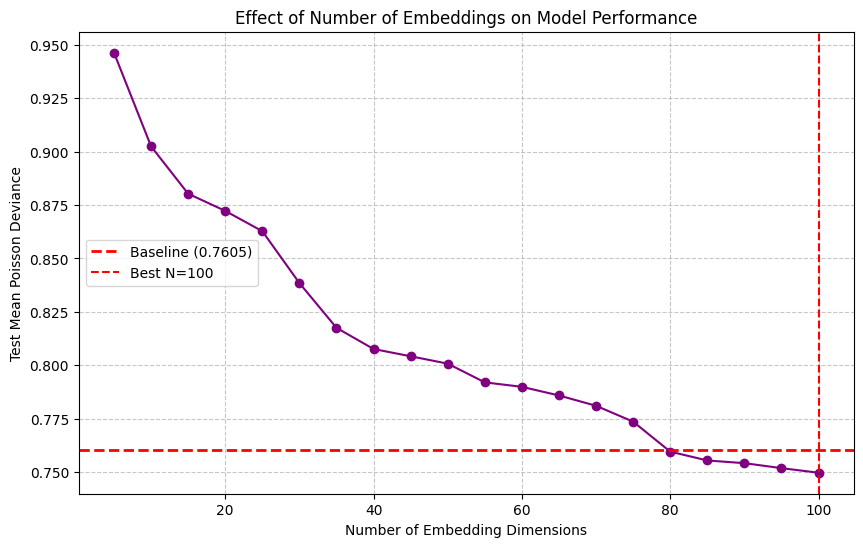

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance
import statsmodels.api as sm
import re

# Helper to ensure 'embed_2' comes before 'embed_10'
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# 1. Setup & Split
# -------------------------------------------------------
# Identify all embedding columns in the merged_df
embedding_cols = [c for c in merged_df2.columns if 'embed_' in c]
# Sort them so we add embed_0, then embed_1, etc.
embedding_cols.sort(key=natural_sort_key)

# We define X explicitly as the embedding columns
X_raw2 = merged_df2[embedding_cols]
y_raw2 = merged_df2['ClaimNb']
offset_raw2 = merged_df2['Exposure']

train_idx2, test_idx2 = train_test_split(merged_df2.index, test_size=0.2, random_state=42)

X_train_raw2 = X_raw2.loc[train_idx2]
y_train2 = y_raw2.loc[train_idx2]
offset_train2 = offset_raw2.loc[train_idx2]

X_test_raw2 = X_raw2.loc[test_idx2]
y_test2 = y_raw2.loc[test_idx2]
offset_test2 = offset_raw2.loc[test_idx2]

# 2. Scale Embeddings ONCE (The Optimization)
# -------------------------------------------------------
# Even though embeddings are often normalized, scaling helps GLM convergence
scaler2 = StandardScaler().set_output(transform='pandas')
X_train_scaled2 = scaler2.fit_transform(X_train_raw2)
X_test_scaled2 = scaler2.transform(X_test_raw2)

print(f"Scaling complete. Total available embeddings: {X_train_scaled2.shape[1]}")

# 3. Efficient Loop via Slicing Columns
# -------------------------------------------------------
deviances2 = []
step_size = 5
max_n = 100 # Or len(embedding_cols) if you want to test all

# range(start, stop, step) -> 10, 20, 30 ... 100
# We start at step_size to ensure we have at least some data
col_counts = range(step_size, max_n + 1, step_size)

for n in col_counts:
    # Select the first n embedding names
    current_cols = embedding_cols[:n]
    
    # Slice the scaled DataFrames using the column names
    X_train_slice2 = X_train_scaled2[current_cols]
    X_test_slice2 = X_test_scaled2[current_cols]
    
    # Add constant to the slice (Statsmodels needs this every time)
    X_train_glm2 = sm.add_constant(X_train_slice2)
    X_test_glm2 = sm.add_constant(X_test_slice2, has_constant='add')
    
    # Fit GLM
    glm2 = sm.GLM(
        endog=y_train2, 
        exog=X_train_glm2, 
        offset=np.log(offset_train2), 
        family=sm.families.Poisson()
    )
    results2 = glm2.fit()
    
    # Predict
    preds2 = results2.predict(exog=X_test_glm2, offset=np.log(offset_test2))
    
    # Score
    mpd2 = mean_poisson_deviance(y_test2, preds2)
    deviances2.append(mpd2)
    print(f"Completed N={n} embeddings | Deviance: {mpd2:.5f}")

target_y = 0.7605 # Baseline to beat

# 4. Plotting
# -------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(col_counts, deviances2, marker='o', linestyle='-', color='purple')
plt.axhline(y=target_y, color='red', linestyle='--', linewidth=2, label=f'Baseline ({target_y})')
plt.title('Effect of Number of Embeddings on Model Performance')
plt.xlabel('Number of Embedding Dimensions')
plt.ylabel('Test Mean Poisson Deviance')
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight the minimum
min_deviance2 = min(deviances2)
best_n2 = col_counts[deviances2.index(min_deviance2)]
plt.axvline(best_n2, color='red', linestyle='--', label=f'Best N={best_n2}')
plt.legend()

plt.savefig('embedding_deviance_plot.png')
print(f"Optimal Embedding Count: {best_n2} (Deviance: {min_deviance2:.4f})")

Optimal Components: 100 (Deviance: 0.7390)


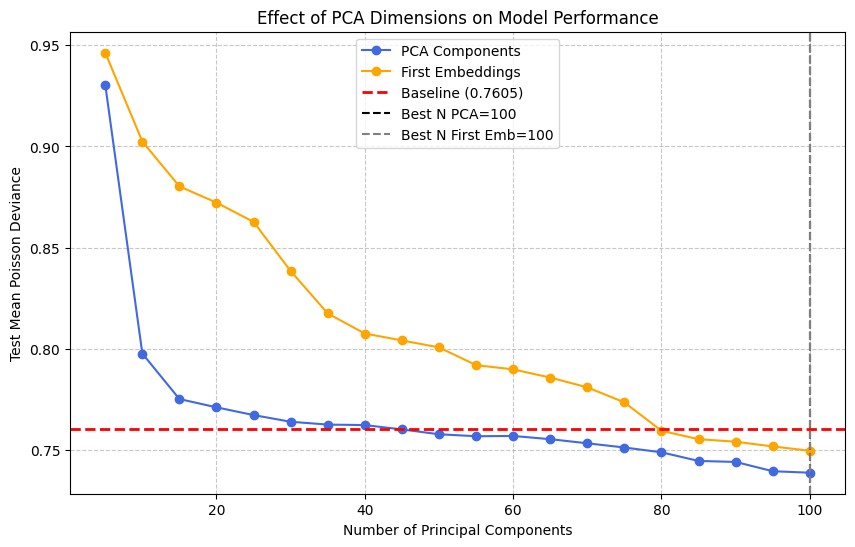

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(component_counts, deviances, marker='o', linestyle='-', color='royalblue', label = 'PCA Components')
plt.plot(col_counts, deviances2, marker='o', linestyle='-', color='orange', label = 'First Embeddings')
plt.axhline(y=target_y, color='red', linestyle='--', linewidth=2, label=f'Baseline ({target_y})')
plt.title('Effect of PCA Dimensions on Model Performance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Test Mean Poisson Deviance')
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight the minimum
min_deviance = min(deviances)
best_n = component_counts[deviances.index(min_deviance)]
plt.axvline(best_n, color='black', linestyle='--', label=f'Best N PCA={best_n}')

# Highlight the minimum
min_deviance2 = min(deviances2)
best_n2 = component_counts[deviances2.index(min_deviance2)]
plt.axvline(best_n2, color='grey', linestyle='--', label=f'Best N First Emb={best_n2}')
plt.legend()

plt.savefig('pca_deviance_plot.png')
print(f"Optimal Components: {best_n} (Deviance: {min_deviance:.4f})")

Running Global PCA on full training set...
PCA Complete. Transformed shape: (40000, 48)
Trained on 1000 rows (PCA=48) | Test Deviance: 0.88299
Trained on 5000 rows (PCA=48) | Test Deviance: 0.81017
Trained on 10000 rows (PCA=48) | Test Deviance: 0.80444
Trained on 15000 rows (PCA=48) | Test Deviance: 0.80402
Trained on 20000 rows (PCA=48) | Test Deviance: 0.80283
Trained on 25000 rows (PCA=48) | Test Deviance: 0.80227
Trained on 30000 rows (PCA=48) | Test Deviance: 0.80203
Trained on 35000 rows (PCA=48) | Test Deviance: 0.80195
Trained on 40000 rows (PCA=48) | Test Deviance: 0.80176


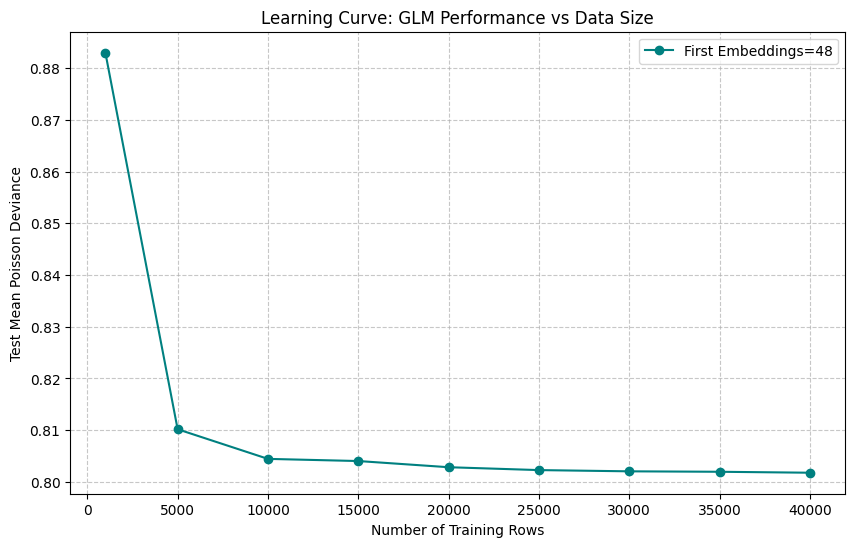

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_poisson_deviance
import statsmodels.api as sm

# 1. Setup & Split
# -------------------------------------------------------
# Split: 10,000 for Test, 40,000 for Training Pool
train_df, test_df = train_test_split(merged_df2, test_size=0.2, random_state=42)

meta_cols = ['ClaimNb', 'Exposure']
pred_cols = merged_df2.columns.difference(meta_cols)

# Prepare Matrices
X_train_raw = train_df[pred_cols]
y_train = train_df['ClaimNb']
offset_train = train_df['Exposure'] 

X_test_raw = test_df[pred_cols]
y_test = test_df['ClaimNb']
offset_test = test_df['Exposure']

# A. Scale based on full 40k training data
scaler = StandardScaler().set_output(transform='pandas')
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)


# Pre-add constant to Test set (since it never changes)
X_test_glm = sm.add_constant(X_test_scaled, has_constant='add')

# 3. Learning Curve Loop
# -------------------------------------------------------
train_sizes = [1000] + list(range(5000, 40001, 5000))
deviances2 = []

for size in train_sizes:
    # A. Slice the first 'size' rows from the ALREADY TRANSFORMED data
    # We use .iloc because X_train_pca_all is a dataframe
    X_train_sub = X_train_scaled.iloc[:size]
    y_train_sub = y_train.iloc[:size]
    off_train_sub = offset_train.iloc[:size]
    
    # B. Add constant for Statsmodels
    X_train_glm = sm.add_constant(X_train_sub)
    
    # C. Fit GLM
    glm = sm.GLM(
        endog=y_train_sub, 
        exog=X_train_glm, 
        offset=np.log(off_train_sub), 
        family=sm.families.Poisson()
    )
    results = glm.fit()
    
    # D. Predict on fixed Test Set
    preds = results.predict(exog=X_test_glm, offset=np.log(offset_test))
    
    # E. Score
    mpd = mean_poisson_deviance(y_test, preds)
    deviances2.append(mpd)


# 4. Plotting
# -------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, deviances2, marker='o', linestyle='-', color='teal', label=f'First Embeddings={n_components}')

plt.title('Learning Curve: GLM Performance vs Data Size')
plt.xlabel('Number of Training Rows')
plt.ylabel('Test Mean Poisson Deviance')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.savefig('pca_learning_curve2.png')
plt.show()

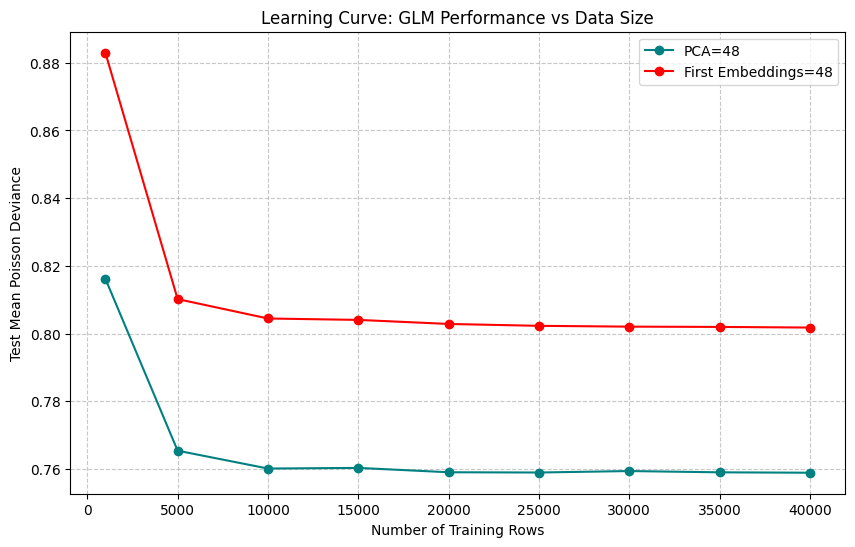

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, deviances, marker='o', linestyle='-', color='teal', label=f'PCA={n_components}')
plt.plot(train_sizes, deviances2, marker='o', linestyle='-', color='red', label=f'First Embeddings={n_components}')
plt.title('Learning Curve: GLM Performance vs Data Size')
plt.xlabel('Number of Training Rows')
plt.ylabel('Test Mean Poisson Deviance')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.savefig('pca_learning_curve_both.png')
plt.show()

## Textbook

In [27]:
dat = pd.read_csv("freMTPL2freq.csv",nrows = 50000)

In [28]:
train_df, test_df = train_test_split(dat, test_size=0.2, random_state=42)
# Save to current directory
# train_df.to_csv('train_df_raw.csv', index=False)

# test_df.to_csv('test_df_raw.csv', index=False)

In [29]:
dat = pd.get_dummies(dat, columns=['VehGas'],drop_first=True)
dat = pd.get_dummies(dat, columns=['VehBrand'],drop_first=True)
dat = pd.get_dummies(dat, columns=['Region'],drop_first=True)
area_remapping = {
    "A": 1,
    "B": 2,
    "C": 3,
    "D": 4,
    "E": 5,
    "F": 6
}
dat["Area"] = dat["Area"].map(area_remapping)

dat['VehPowerGLM'] = pd.Categorical(np.minimum(dat['VehPower'], 9))

dat['VehAgeGLM'] = pd.cut(
    dat['VehAge'],
    bins=[0, 5, 12, 101],
    labels=["0-5", "6-12", "12+"],
    include_lowest=True
)

dat['DrivAgeGLM'] = pd.cut(
    dat['DrivAge'],
    bins=[18, 20, 25, 30, 40, 50, 70, 101],
    labels=["18-20", "21-25", "26-30", "31-40", "41-50", "51-70", "71+"],
    include_lowest=True
)

dat['BonusMalusGLM'] = np.minimum(dat['BonusMalus'], 150)

dat['DensityGLM'] = np.log(dat["Density"].astype(float))

dat = pd.get_dummies(dat, columns=['DrivAgeGLM'],drop_first=True)
dat = pd.get_dummies(dat, columns=['VehAgeGLM'],drop_first=True)
dat = pd.get_dummies(dat, columns=['VehPowerGLM'],drop_first=True)

dat = dat.drop(['IDpol',"VehPower", "VehAge", "DrivAge", "BonusMalus","Density"], axis = 1)

In [30]:
dat = dat.astype('float32')
dat

,ClaimNb,Exposure,Area,VehGas_Regular,VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,VehBrand_B14,VehBrand_B2,...,DrivAgeGLM_41-50,DrivAgeGLM_51-70,DrivAgeGLM_71+,VehAgeGLM_6-12,VehAgeGLM_12+,VehPowerGLM_5,VehPowerGLM_6,VehPowerGLM_7,VehPowerGLM_8,VehPowerGLM_9
0,1.0,0.10,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.77,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.75,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.09,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.84,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,0.83,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,0.0,0.09,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
49997,0.0,0.77,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
49998,0.0,0.02,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [10]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 2. Split Data
# ---------------------------------------------------------
train_df, test_df = train_test_split(dat, test_size=0.2, random_state=42)

# Separate Predictors from Meta Data
# Using .difference() is safer/faster for 3000 columns
meta_cols = ['ClaimNb', 'Exposure']
pred_cols = dat.columns.difference(meta_cols)

X_train = train_df[pred_cols]
meta_train = train_df[meta_cols]

X_test = test_df[pred_cols]
meta_test = test_df[meta_cols]

# Concatenate (Join)
final_train = pd.concat([X_train, meta_train], axis=1)
final_test = pd.concat([X_test, meta_test], axis=1)

print(final_train.head())

       Area  BonusMalusGLM  DensityGLM  DrivAgeGLM_21-25  DrivAgeGLM_26-30  \
39087   4.0           50.0    6.783325               0.0               0.0   
30893   3.0           50.0    5.342334               0.0               0.0   
45278   3.0           57.0    5.739793               0.0               0.0   
16398   3.0           85.0    5.093750               0.0               1.0   
13653   3.0           50.0    4.653960               0.0               0.0   

       DrivAgeGLM_31-40  DrivAgeGLM_41-50  DrivAgeGLM_51-70  DrivAgeGLM_71+  \
39087               0.0               0.0               1.0             0.0   
30893               0.0               0.0               0.0             1.0   
45278               1.0               0.0               0.0             0.0   
16398               0.0               0.0               0.0             0.0   
13653               0.0               0.0               1.0             0.0   

       Region_R21  ...  VehBrand_B5  VehBrand_B6  VehGas

In [11]:
import statsmodels.api as sm
import numpy as np

# ---------------------------------------------------------
# 1. Prepare Training Data
# ---------------------------------------------------------
# Identify predictor columns (The PCs)
# We exclude 'response' and 'offset' to get just the X matrix
predictors = [c for c in final_train.columns if c not in ['ClaimNb', 'Exposure']]

X_train = final_train[predictors]
y_train = final_train['ClaimNb']

# CRITICAL: Statsmodels does not add an intercept by default.
# PCA centers data, but you still need an intercept for the baseline rate.
X_train = sm.add_constant(X_train)

# Define the offset for training
# NOTE: If 'offset' is raw exposure (e.g., years), use np.log(final_train['offset'])
train_offset = np.log(final_train['Exposure'])

# ---------------------------------------------------------
# 2. Fit the Poisson GLM
# ---------------------------------------------------------
# Instantiate the model
glm_model = sm.GLM(
    endog=y_train, 
    exog=X_train, 
    offset=train_offset,
    family=sm.families.Poisson()
)

# Fit the model
results = glm_model.fit()

print(results.summary())

# ---------------------------------------------------------
# 3. Predict on Test Data
# ---------------------------------------------------------
X_test = final_test[predictors]
X_test = sm.add_constant(X_test, has_constant='add') # Ensure structure matches Train

# Define offset for testing
test_offset = np.log(final_test['Exposure'])

# Generate Predictions (Expected Counts)
# We pass the test offset here so predictions are scaled correctly
predictions = results.predict(exog=X_test, offset=test_offset)

# Add predictions back to the test dataframe for analysis
final_test['predicted_counts'] = predictions

print("\nFirst 5 Predictions:")
print(final_test[['ClaimNb', 'Exposure', 'predicted_counts']].head())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:                40000
Model:                            GLM   Df Residuals:                    39951
Model Family:                 Poisson   Df Model:                           48
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24501.
Date:                Thu, 27 Nov 2025   Deviance:                       29996.
Time:                        14:12:33   Pearson chi2:                 1.34e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2135
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.7888      0.151  

In [12]:
# 1. Access the Poisson family object from your fitted model
poisson_family = results.family

# 2. Calculate Total Deviance for the Test Set
# Inputs: (Endog/Actual, Mu/Predicted)
test_deviance_total = poisson_family.deviance(
    final_test['ClaimNb'], 
    final_test['predicted_counts']
)

# 3. Calculate Mean Deviance
test_mean_deviance = test_deviance_total / len(final_test)

print(f"Test Mean Poisson Deviance: {test_mean_deviance:.4f}")

Test Mean Poisson Deviance: 0.7605


Test Set Size (Fixed): 10000 rows
----------------------------------------
Training on 2000 rows (  5%) -> Deviance: 0.7839
Training on 4000 rows ( 10%) -> Deviance: 0.7701
Training on 6000 rows ( 15%) -> Deviance: 0.7648
Training on 8000 rows ( 20%) -> Deviance: 0.7634
Training on 10000 rows ( 25%) -> Deviance: 0.7621
Training on 12000 rows ( 30%) -> Deviance: 0.7617
Training on 14000 rows ( 35%) -> Deviance: 0.7612
Training on 15999 rows ( 40%) -> Deviance: 0.7603
Training on 18000 rows ( 45%) -> Deviance: 0.7603
Training on 19999 rows ( 50%) -> Deviance: 0.7604
Training on 21999 rows ( 55%) -> Deviance: 0.7607
Training on 24000 rows ( 60%) -> Deviance: 0.7604
Training on 26000 rows ( 65%) -> Deviance: 0.7606
Training on 28000 rows ( 70%) -> Deviance: 0.7606
Training on 30000 rows ( 75%) -> Deviance: 0.7605
Training on 31999 rows ( 80%) -> Deviance: 0.7607
Training on 34000 rows ( 85%) -> Deviance: 0.7605
Training on 36000 rows ( 90%) -> Deviance: 0.7606
Training on 38000 rows ( 95%)

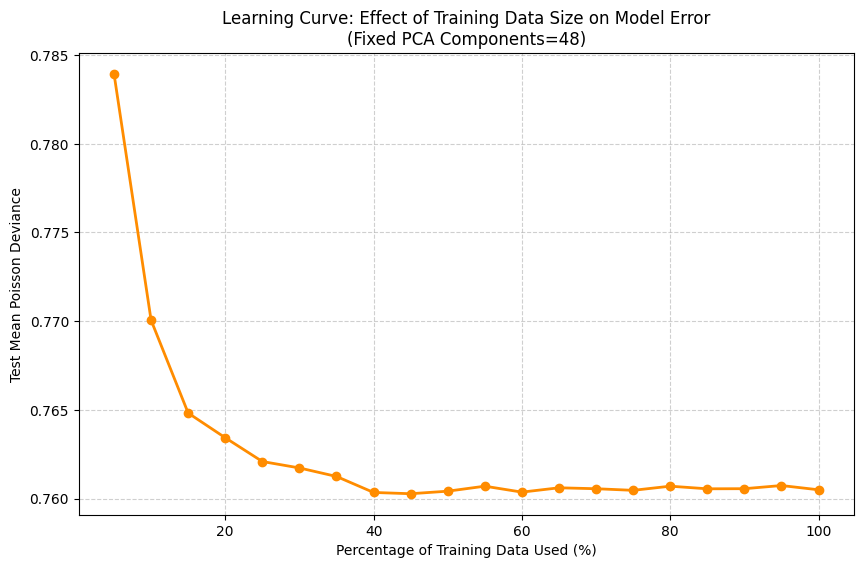

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance
import statsmodels.api as sm

# 2. Initial Fixed Split (The "Fair Comparison" Setup)
# -------------------------------------------------------
# We hold out 20% as a fixed benchmark. 
# We will never train on this, only evaluate.
train_full, test_df = train_test_split(dat, test_size=0.2, random_state=42)

meta_cols = ['ClaimNb', 'Exposure']
pred_cols = dat.columns.difference(meta_cols)

# Prepare the Fixed Test Set
X_test_raw = test_df[pred_cols]
y_test = test_df['ClaimNb']
offset_test = test_df['Exposure']

# 3. Learning Curve Loop
# -------------------------------------------------------
train_proportions = np.linspace(0.05, 1.0, 20) # 10%, 20% ... 100%
deviances = []
n_pca_components = 48 # Keep model complexity constant to isolate data size effect

print(f"Test Set Size (Fixed): {len(test_df)} rows")
print("-" * 40)

for prop in train_proportions:
    # A. Subsample the Training Data
    # We take the first N rows (shuffling happened in train_test_split already)
    n_samples = int(len(train_full) * prop)
    train_subset = train_full.iloc[:n_samples]
    
    # Prepare Subset Matrices
    X_train_sub = train_subset[pred_cols]
    y_train_sub = train_subset['ClaimNb']
    offset_train_sub = train_subset['Exposure']
    
    # C. Fit GLM
    X_train_glm = sm.add_constant(X_train_sub)
    X_test_glm = sm.add_constant(X_test_raw, has_constant='add')
    
    try:
        glm = sm.GLM(
            endog=y_train_sub, 
            exog=X_train_glm, 
            offset=np.log(offset_train_sub), 
            family=sm.families.Poisson()
        )
        results = glm.fit()
        
        # D. Predict on Fixed Test Set
        preds = results.predict(exog=X_test_glm, offset=np.log(offset_test))
        mpd = mean_poisson_deviance(y_test, preds)
        deviances.append(mpd)
        print(f"Training on {n_samples:4d} rows ({prop*100:3.0f}%) -> Deviance: {mpd:.4f}")
        
    except Exception as e:
        print(f"Training on {n_samples} rows failed to converge.")
        deviances.append(None)

# 4. Plot Learning Curve
# -------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(train_proportions * 100, deviances, marker='o', linewidth=2, color='darkorange')

plt.title(f'Learning Curve: Effect of Training Data Size on Model Error\n(Fixed PCA Components={n_pca_components})')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Test Mean Poisson Deviance')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

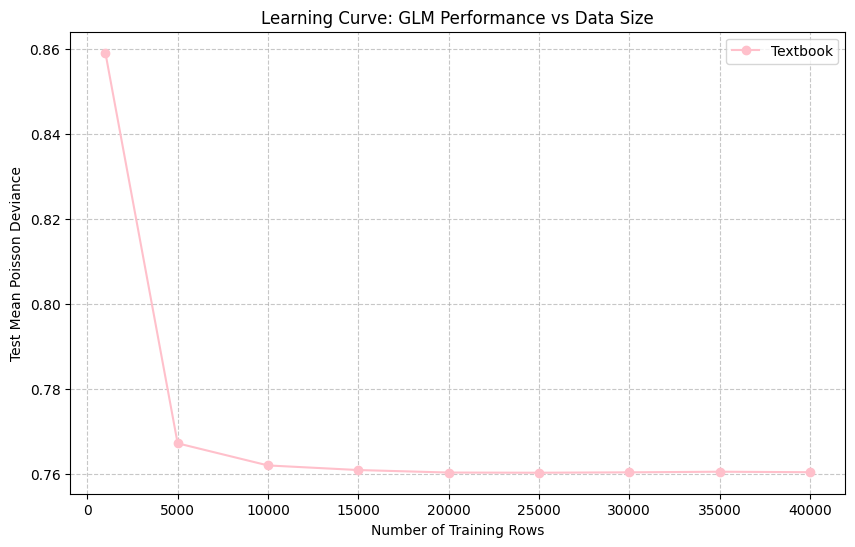

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_poisson_deviance
import statsmodels.api as sm

# 1. Setup & Split
# -------------------------------------------------------
# Split: 10,000 for Test, 40,000 for Training Pool
train_df, test_df = train_test_split(dat, test_size=0.2, random_state=42)

meta_cols = ['ClaimNb', 'Exposure']
pred_cols = dat.columns.difference(meta_cols)

# Prepare Matrices
X_train_raw = train_df[pred_cols]
y_train = train_df['ClaimNb']
offset_train = train_df['Exposure'] 

X_test_raw = test_df[pred_cols]
y_test = test_df['ClaimNb']
offset_test = test_df['Exposure']

# Pre-add constant to Test set (since it never changes)
X_test_glm = sm.add_constant(X_test_raw, has_constant='add')

# 3. Learning Curve Loop
# -------------------------------------------------------
train_sizes = [1000] + list(range(5000, 40001, 5000))
deviances3 = []

for size in train_sizes:
    # A. Slice the first 'size' rows from the ALREADY TRANSFORMED data
    # We use .iloc because X_train_pca_all is a dataframe
    X_train_sub = X_train_raw.iloc[:size]
    y_train_sub = y_train.iloc[:size]
    off_train_sub = offset_train.iloc[:size]
    
    # B. Add constant for Statsmodels
    X_train_glm = sm.add_constant(X_train_sub)
    
    # C. Fit GLM
    glm = sm.GLM(
        endog=y_train_sub, 
        exog=X_train_glm, 
        offset=np.log(off_train_sub), 
        family=sm.families.Poisson()
    )
    results = glm.fit()
    
    # D. Predict on fixed Test Set
    preds = results.predict(exog=X_test_glm, offset=np.log(offset_test))
    
    # E. Score
    mpd = mean_poisson_deviance(y_test, preds)
    deviances3.append(mpd)
    

# 4. Plotting
# -------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, deviances3, marker='o', linestyle='-', color='pink', label=f'Textbook')

plt.title('Learning Curve: GLM Performance vs Data Size')
plt.xlabel('Number of Training Rows')
plt.ylabel('Test Mean Poisson Deviance')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.savefig('pca_learning_curve3.png')
plt.show()

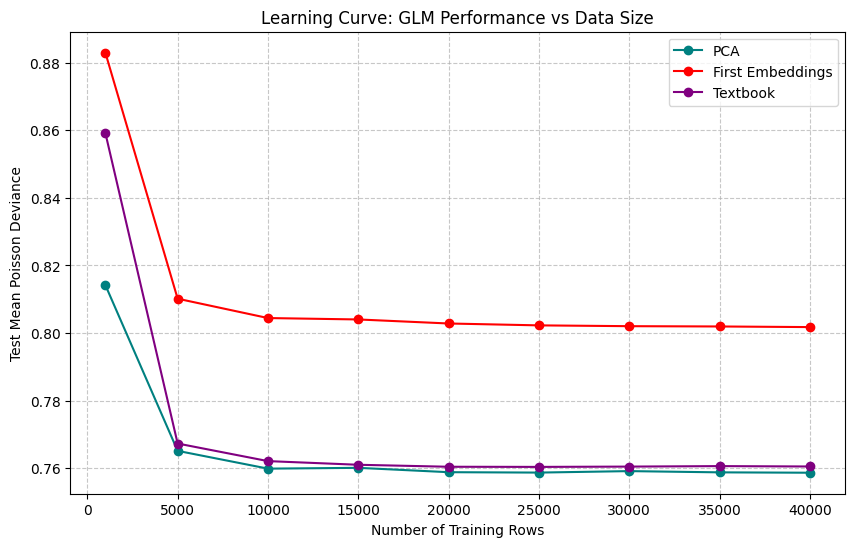

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, deviances, marker='o', linestyle='-', color='teal', label=f'PCA')
plt.plot(train_sizes, deviances2, marker='o', linestyle='-', color='red', label=f'First Embeddings')
plt.plot(train_sizes, deviances3, marker='o', linestyle='-', color='purple', label=f'Textbook')
plt.title('Learning Curve: GLM Performance vs Data Size')
plt.xlabel('Number of Training Rows')
plt.ylabel('Test Mean Poisson Deviance')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.savefig('pca_learning_curve_all.png')
plt.show()

## Neural Net

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers

# 1. Prepare Data specific for Neural Network
# -------------------------------------------------------
# Neural Nets require inputs to be passed as a list if there are multiple input layers
# X_train_pca_df: Your PCA features (Training)
# offset_train: Your Exposure/Offset (Training)
# y_train: Your Claim Counts (Training)
# 1. Setup & Split
# -------------------------------------------------------
# (Assuming df is loaded)
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

meta_cols = ['ClaimNb', 'Exposure']
pred_cols = merged_df.columns.difference(meta_cols)

X_train_raw = train_df[pred_cols]
y_train = train_df['ClaimNb']
offset_train = train_df['Exposure'] 

X_test_raw = test_df[pred_cols]
y_test = test_df['ClaimNb']
offset_test = test_df['Exposure']

# 2. Scale & Run PCA ONCE (The Optimization)
# -------------------------------------------------------
scaler = StandardScaler().set_output(transform='pandas')
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Fit PCA for the MAXIMUM number of components you want to test (e.g., 50)
max_n = 48
pca = PCA(n_components=max_n).set_output(transform='pandas')

# Create the "Master" PCA DataFrames
X_train_pca_all = pca.fit_transform(X_train_scaled)
X_test_pca_all = pca.transform(X_test_scaled)

print(f"PCA fit complete. Shape: {X_train_pca_all.shape}")
# Calculate the initial bias (lambda0)
# This sets the starting point of the network to the global average frequency
# Formula: log(Total Claims / Total Exposure)
mean_frequency = y_train.sum() / offset_train.sum()
initial_bias = np.log(mean_frequency)

n_features = X_train_pca_all.shape[1] # e.g., 40, 50, 100 based on your PCA

# 2. Define the Model Architecture
# -------------------------------------------------------
# Input A: The Predictors (Design Matrix)
input_design = keras.Input(shape=(n_features,), name='Design')

# Input B: The Offset (Volume/Exposure)
input_vol = keras.Input(shape=(1,), name='Vol')

# Hidden Layers (The "Network" branch)
# Structure matches your image: 20 -> 15 -> 10 -> 1
x = layers.Dense(20, activation='tanh', name='FNLayer1')(input_design)
x = layers.Dense(15, activation='tanh', name='FNLayer2')(x)
x = layers.Dense(10, activation='tanh', name='FNLayer3')(x)

# Final Network Layer (Predicts the Rate)
# Activation is exponential (ensures rate > 0)
# We initialize weights to 0 and bias to log(mean_freq) to match the R code logic
rate_layer = layers.Dense(1, 
                          activation='exponential', 
                          name='Network',
                          kernel_initializer='zeros',
                          bias_initializer=initializers.Constant(initial_bias))(x)

# Combine: Rate * Volume = Expected Count
# This replaces the standard GLM offset mechanism
output = layers.Multiply(name='Multiply')([rate_layer, input_vol])

# 3. Compile Model
# -------------------------------------------------------
model = keras.Model(inputs=[input_design, input_vol], outputs=output)

model.compile(optimizer='adam', loss='poisson')

model.summary()

# 4. Training
# -------------------------------------------------------
# Note: We pass inputs as a list: [Predictors, Offset]
history = model.fit(
    x=[X_train_pca_all, offset_train.values], # Inputs
    y=y_train.values,                         # Target (Counts)
    validation_split=0.2,
    epochs=50,
    batch_size=1024,
    verbose=1
)

# 5. Prediction
# -------------------------------------------------------
# Pass test predictors and test offset
preds = model.predict([X_test_pca_all, offset_test.values])

PCA fit complete. Shape: (40000, 48)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Design (InputLayer) │ (None, 48)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FNLayer1 (Dense)    │ (None, 20)        │        980 │ Design[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FNLayer2 (Dense)    │ (None, 15)        │        315 │ FNLayer1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FNLayer3 (Dense)    │ (None, 10)        │        160 │ FNLayer2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Network (Dense)     │ (None, 1)         │         11 │ FNLayer3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Vol (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Multiply (Multiply) │ (None, 1)         │          0 │ Network[0][0],    │
│                     │                   │            │ Vol[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,466 (5.73 KB)

 Trainable params: 1,466 (5.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7174 - val_loss: 0.7114
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6917 - val_loss: 0.6767
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6575 - val_loss: 0.6491
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6333 - val_loss: 0.6322
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6202 - val_loss: 0.6243
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6135 - val_loss: 0.6199
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6091 - val_loss: 0.6170
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6060 - val_loss: 0.6147
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6032 - val_loss: 0.6130
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6007 - val_loss: 0.6117
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5986 - val_loss: 0.6106
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5966 - val_lo

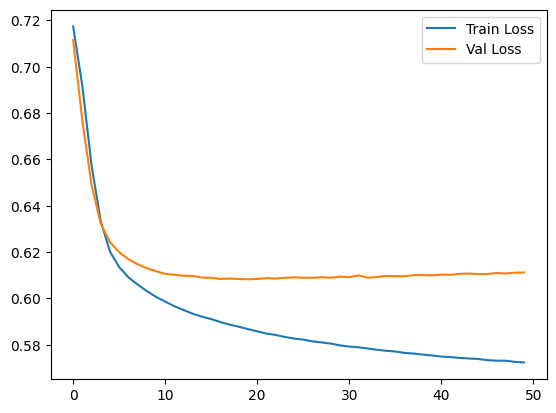

In [43]:
# Assuming 'history' is the object returned by model.fit()
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.savefig('pca_nn.png')
plt.show()

In [44]:
from sklearn.metrics import mean_poisson_deviance

# 1. Generate Predictions (if not already done)
# Returns a 2D array: [[0.02], [0.05], ...]
nn_preds = model.predict([X_test_pca_all, offset_test.values])

# 2. Flatten to 1D array
# Converts to: [0.02, 0.05, ...]
nn_preds_flat = nn_preds.flatten()

# 3. Calculate Mean Poisson Deviance
nn_mpd = mean_poisson_deviance(y_test, nn_preds_flat)

print(f"Neural Network Test Mean Poisson Deviance: {nn_mpd:.5f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
Neural Network Test Mean Poisson Deviance: 0.77775


In [45]:
# For Textbook data
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers
# 1. Prepare Data specific for Neural Network
# -------------------------------------------------------
# Neural Nets require inputs to be passed as a list if there are multiple input layers
# X_train_pca_df: Your PCA features (Training)
# offset_train: Your Exposure/Offset (Training)
# y_train: Your Claim Counts (Training)
# 1. Setup & Split
# -------------------------------------------------------
# (Assuming df is loaded)
train_df, test_df = train_test_split(dat, test_size=0.2, random_state=42)

meta_cols = ['ClaimNb', 'Exposure']
pred_cols = dat.columns.difference(meta_cols)

X_train_raw = train_df[pred_cols]
y_train = train_df['ClaimNb']
offset_train = train_df['Exposure'] 

X_test_raw = test_df[pred_cols]
y_test = test_df['ClaimNb']
offset_test = test_df['Exposure']


# Calculate the initial bias (lambda0)
# This sets the starting point of the network to the global average frequency
# Formula: log(Total Claims / Total Exposure)
mean_frequency = y_train.sum() / offset_train.sum()
initial_bias = np.log(mean_frequency)

n_features = X_train_raw.shape[1] # e.g., 40, 50, 100 based on your PCA

# 2. Define the Model Architecture
# -------------------------------------------------------
# Input A: The Predictors (Design Matrix)
input_design = keras.Input(shape=(n_features,), name='Design')

# Input B: The Offset (Volume/Exposure)
input_vol = keras.Input(shape=(1,), name='Vol')

# Hidden Layers (The "Network" branch)
# Structure matches your image: 20 -> 15 -> 10 -> 1
x = layers.Dense(20, activation='tanh', name='FNLayer1')(input_design)
x = layers.Dense(15, activation='tanh', name='FNLayer2')(x)
x = layers.Dense(10, activation='tanh', name='FNLayer3')(x)

# Final Network Layer (Predicts the Rate)
# Activation is exponential (ensures rate > 0)
# We initialize weights to 0 and bias to log(mean_freq) to match the R code logic
rate_layer = layers.Dense(1, 
                          activation='exponential', 
                          name='Network',
                          kernel_initializer='zeros',
                          bias_initializer=initializers.Constant(initial_bias))(x)

# Combine: Rate * Volume = Expected Count
# This replaces the standard GLM offset mechanism
output = layers.Multiply(name='Multiply')([rate_layer, input_vol])

# 3. Compile Model
# -------------------------------------------------------
model = keras.Model(inputs=[input_design, input_vol], outputs=output)

model.compile(optimizer='adam', loss='poisson')

model.summary()

# 4. Training
# -------------------------------------------------------
# Note: We pass inputs as a list: [Predictors, Offset]
history = model.fit(
    x=[X_train_raw, offset_train.values], # Inputs
    y=y_train.values,                         # Target (Counts)
    validation_split=0.2,
    epochs=50,
    batch_size=1024,
    verbose=1
)

# 5. Prediction
# -------------------------------------------------------
# Pass test predictors and test offset
preds = model.predict([X_test_raw, offset_test.values])

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Design (InputLayer) │ (None, 48)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FNLayer1 (Dense)    │ (None, 20)        │        980 │ Design[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FNLayer2 (Dense)    │ (None, 15)        │        315 │ FNLayer1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FNLayer3 (Dense)    │ (None, 10)        │        160 │ FNLayer2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Network (Dense)     │ (None, 1)         │         11 │ FNLayer3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Vol (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Multiply (Multiply) │ (None, 1)         │          0 │ Network[0][0],    │
│                     │                   │            │ Vol[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,466 (5.73 KB)

 Trainable params: 1,466 (5.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7219 - val_loss: 0.7244
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7184 - val_loss: 0.7169
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7026 - val_loss: 0.6895
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6656 - val_loss: 0.6499
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6324 - val_loss: 0.6265
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6166 - val_loss: 0.6156
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6082 - val_loss: 0.6093
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6029 - val_loss: 0.6051
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5996 - val_loss: 0.6010
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5972 - val_loss: 0.6014
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5959 - val_loss: 0.5960
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5921 - val_lo

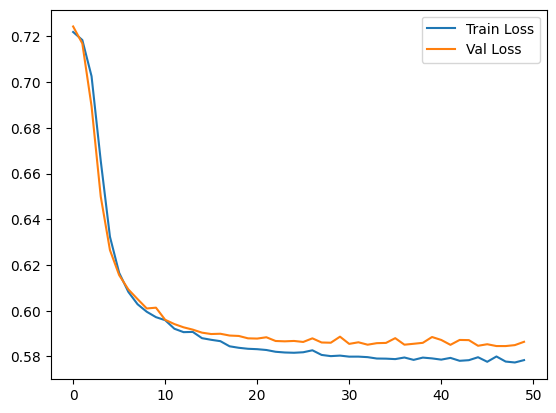

In [46]:
# Assuming 'history' is the object returned by model.fit()
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.savefig('raw_nn.png')
plt.show()

In [47]:
from sklearn.metrics import mean_poisson_deviance

# 1. Generate Predictions (if not already done)
# Returns a 2D array: [[0.02], [0.05], ...]
nn_preds = model.predict([X_test_raw, offset_test.values])

# 2. Flatten to 1D array
# Converts to: [0.02, 0.05, ...]
nn_preds_flat = nn_preds.flatten()

# 3. Calculate Mean Poisson Deviance
nn_mpd = mean_poisson_deviance(y_test, nn_preds_flat)

print(f"Neural Network Test Mean Poisson Deviance: {nn_mpd:.5f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
Neural Network Test Mean Poisson Deviance: 0.72590
